# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="Tennis.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
actions = np.random.randn(num_agents, action_size)     # select an action (for each agent)
print('actions\n',actions)
print('actions shape\n',actions.shape)

actions = np.clip(actions, -1, 1) 
env_info = env.step(actions)[brain_name]

next_states = env_info.vector_observations
print('next_states\n',next_states)
print('next_states shape\n',next_states.shape)

rewards = env_info.rewards 
print('rewards\n',rewards)


dones = env_info.local_done
print('dones\n',dones)


In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Solution: [MADDPG](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf) for Mixed Cooperative-Competitive Environments
#### 1. Import the Necessary Packages

In [1]:
import torch
import numpy as np
from maddpg import Agent
import os
from collections import deque

!pip install progressbar
import progressbar as pb

import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


#### 2. Information from Environment

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


#### 3. Train the Agent

In [3]:
def main(n_episodes=2000, print_every=10):
    """ Training MADDPG agents
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        print_every: printing results 
    """
    model_dir= os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)
    
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    best_score = -np.inf
    scores_window = deque(maxlen=100)
    scores_all = []
    moving_avgs = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        
        states = np.reshape(env_info.vector_observations, (1, -1))  # flatten states(2, 24) to (1, 48)
        agent0.reset()
        agent1.reset()
        scores = np.zeros(num_agents)
        while True:
            A0 = agent0.act(states, add_noise=True)                 # get A0 shape(1, 2)
            A1 = agent1.act(states, add_noise=True)                 # get A1 shape(1, 2)
            actions = np.concatenate((A0, A1), axis=0).flatten()    # combinate A0, A1 as A
            
            env_info = env.step(actions)[brain_name]           
            next_states = np.reshape(env_info.vector_observations, (1, -1))  # reshape states (1, 48) for NN
            rewards = env_info.rewards                       
            dones = env_info.local_done                        
            agent0.step(states, actions, rewards[0], next_states, dones[0])  #  input <S, A, R0, S', done0> 
            agent1.step(states, actions, rewards[1], next_states, dones[1])  #  input <S, A, R1, S', done1>
            scores += np.max(rewards)                          
            states = next_states                               
            if np.any(dones):                                   
                break

        epi_best_score = np.max(scores)
        scores_all.append(epi_best_score)
        scores_window.append(epi_best_score)
        moving_avgs.append(np.mean(scores_window))

        # print results
        if i_episode % print_every == 0:
            timer.update(i_episode) 
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.4f}\tMoving Average: {:.4f}'.format(
                i_episode-print_every, i_episode, np.max(scores_all[-print_every:]), moving_avgs[-1]))
            
        if epi_best_score > best_score:
            torch.save(agent0.actor_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent0_actor.pt'))
            torch.save(agent0.critic_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent0_critic.pt'))
            torch.save(agent1.actor_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent1_actor.pt'))
            torch.save(agent1.critic_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent1_critic.pt'))
            best_score = epi_best_score 
            print('\rEpisode {:0>4d}\tMax Reward: {:.4f}..save checkpoint in model_dir'.format(i_episode, best_score))
            
        
        if i_episode >= 100 and moving_avgs[-1]>= 0.5:
            torch.save(agent0.actor_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent0_actor.pt'))
            torch.save(agent0.critic_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent0_critic.pt'))
            torch.save(agent1.actor_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent1_actor.pt'))
            torch.save(agent1.critic_local.state_dict(),os.path.join(model_dir, 'checkpoint_agent1_critic.pt'))
            print('\n Solved in Episode {:0>4d}\t Score: {:.4f}\tMoving Avgs Score: {:.4f}'\
                  .format(i_episode, epi_best_score, moving_avgs[-1]))
            timer.finish()                                     
            break
            
    return scores_all, moving_avgs

In [4]:
agent0 = Agent(state_size, action_size, agent_id=0, seed=0)
agent1 = Agent(state_size, action_size, agent_id=1, seed=0)
scores, moving_average = main()

Episode 0001	Max Reward: 0.0000..save checkpoint in model_dir
Episode 0008	Max Reward: 0.1000..save checkpoint in model_dir


Episodes 0000-0010	Max Reward: 0.1000	Moving Average: 0.0200


Episodes 0010-0020	Max Reward: 0.0000	Moving Average: 0.0100


Episodes 0020-0030	Max Reward: 0.1000	Moving Average: 0.0133
Episode 0039	Max Reward: 0.2000..save checkpoint in model_dir


Episodes 0030-0040	Max Reward: 0.2000	Moving Average: 0.0225


Episodes 0040-0050	Max Reward: 0.1000	Moving Average: 0.0220


Episodes 0050-0060	Max Reward: 0.1000	Moving Average: 0.0217


Episodes 0060-0070	Max Reward: 0.1000	Moving Average: 0.0243


Episodes 0070-0080	Max Reward: 0.1000	Moving Average: 0.0225


Episodes 0080-0090	Max Reward: 0.2000	Moving Average: 0.0267


Episodes 0090-0100	Max Reward: 0.2000	Moving Average: 0.0310


Episodes 0100-0110	Max Reward: 0.1000	Moving Average: 0.0330


Episodes 0110-0120	Max Reward: 0.2000	Moving Average: 0.0390


Episodes 0120-0130	Max Reward: 0.2000	Moving Average: 0.0430


Episodes 0130-0140	Max Reward: 0.1000	Moving Average: 0.0440


Episodes 0140-0150	Max Reward: 0.2000	Moving Average: 0.0470


Episodes 0150-0160	Max Reward: 0.2000	Moving Average: 0.0500


Episodes 0160-0170	Max Reward: 0.2000	Moving Average: 0.0560


Episodes 0170-0180	Max Reward: 0.1000	Moving Average: 0.0600


Episodes 0180-0190	Max Reward: 0.2000	Moving Average: 0.0590


Episodes 0190-0200	Max Reward: 0.1000	Moving Average: 0.0580


Episodes 0200-0210	Max Reward: 0.1000	Moving Average: 0.0620


Episodes 0210-0220	Max Reward: 0.1000	Moving Average: 0.0640


Episodes 0220-0230	Max Reward: 0.2000	Moving Average: 0.0660


Episodes 0230-0240	Max Reward: 0.2000	Moving Average: 0.0710


Episodes 0240-0250	Max Reward: 0.1000	Moving Average: 0.0760


Episodes 0250-0260	Max Reward: 0.2000	Moving Average: 0.0820


Episodes 0260-0270	Max Reward: 0.2000	Moving Average: 0.0810


Episodes 0270-0280	Max Reward: 0.2000	Moving Average: 0.0840


Episodes 0280-0290	Max Reward: 0.2000	Moving Average: 0.0860


Episodes 0290-0300	Max Reward: 0.2000	Moving Average: 0.0850


Episodes 0300-0310	Max Reward: 0.2000	Moving Average: 0.0890


Episodes 0310-0320	Max Reward: 0.2000	Moving Average: 0.0900
Episode 0322	Max Reward: 0.3000..save checkpoint in model_dir


Episodes 0320-0330	Max Reward: 0.3000	Moving Average: 0.0950


Episodes 0330-0340	Max Reward: 0.3000	Moving Average: 0.0970
Episode 0347	Max Reward: 0.4000..save checkpoint in model_dir


Episodes 0340-0350	Max Reward: 0.4000	Moving Average: 0.1060


Episodes 0350-0360	Max Reward: 0.2000	Moving Average: 0.1010


Episodes 0360-0370	Max Reward: 0.3000	Moving Average: 0.1030


Episodes 0370-0380	Max Reward: 0.2000	Moving Average: 0.1040


Episodes 0380-0390	Max Reward: 0.2000	Moving Average: 0.1040
Episode 0397	Max Reward: 0.7000..save checkpoint in model_dir


Episodes 0390-0400	Max Reward: 0.7000	Moving Average: 0.1139


Episodes 0400-0410	Max Reward: 0.2000	Moving Average: 0.1149


Episodes 0410-0420	Max Reward: 0.4000	Moving Average: 0.1239


Episodes 0420-0430	Max Reward: 0.4000	Moving Average: 0.1269


Episodes 0430-0440	Max Reward: 0.3000	Moving Average: 0.1329


Episodes 0440-0450	Max Reward: 0.6000	Moving Average: 0.1329


Episodes 0450-0460	Max Reward: 0.3000	Moving Average: 0.1409


Episodes 0460-0470	Max Reward: 0.2000	Moving Average: 0.1409


Episodes 0470-0480	Max Reward: 0.4000	Moving Average: 0.1459


Episodes 0480-0490	Max Reward: 0.5000	Moving Average: 0.1539


Episodes 0490-0500	Max Reward: 0.2000	Moving Average: 0.1480


Episodes 0500-0510	Max Reward: 0.2000	Moving Average: 0.1480


Episodes 0510-0520	Max Reward: 0.4000	Moving Average: 0.1459


Episodes 0520-0530	Max Reward: 0.2000	Moving Average: 0.1459


Episodes 0530-0540	Max Reward: 0.5000	Moving Average: 0.1429


Episodes 0540-0550	Max Reward: 0.3000	Moving Average: 0.1409


Episodes 0550-0560	Max Reward: 0.6000	Moving Average: 0.1479


Episodes 0560-0570	Max Reward: 0.2000	Moving Average: 0.1529


Episodes 0570-0580	Max Reward: 0.6000	Moving Average: 0.1619
Episode 0585	Max Reward: 0.9000..save checkpoint in model_dir


Episodes 0580-0590	Max Reward: 0.9000	Moving Average: 0.1669
Episode 0594	Max Reward: 1.1000..save checkpoint in model_dir


Episodes 0590-0600	Max Reward: 1.1000	Moving Average: 0.2079


Episodes 0600-0610	Max Reward: 0.4000	Moving Average: 0.2109


Episodes 0610-0620	Max Reward: 0.7000	Moving Average: 0.2260


Episodes 0620-0630	Max Reward: 0.8000	Moving Average: 0.2400


Episodes 0630-0640	Max Reward: 0.7000	Moving Average: 0.2530


Episodes 0640-0650	Max Reward: 0.5000	Moving Average: 0.2620


Episodes 0650-0660	Max Reward: 0.9000	Moving Average: 0.2800


Episodes 0660-0670	Max Reward: 0.4000	Moving Average: 0.2820
Episode 0676	Max Reward: 1.7000..save checkpoint in model_dir


Episodes 0670-0680	Max Reward: 1.7000	Moving Average: 0.3179


Episodes 0680-0690	Max Reward: 0.6000	Moving Average: 0.3269


Episodes 0690-0700	Max Reward: 1.5000	Moving Average: 0.3219


Episodes 0700-0710	Max Reward: 0.6000	Moving Average: 0.3399


Episodes 0710-0720	Max Reward: 1.5000	Moving Average: 0.3469
Episode 0721	Max Reward: 2.9000..save checkpoint in model_dir


Episodes 0720-0730	Max Reward: 2.9000	Moving Average: 0.3769
Episode 0735	Max Reward: 3.1000..save checkpoint in model_dir


Episodes 0730-0740	Max Reward: 3.1000	Moving Average: 0.4149
Episode 0746	Max Reward: 4.9000..save checkpoint in model_dir



 Solved in Episode 0748	 Score: 1.9000	Moving Avgs Score: 0.5139


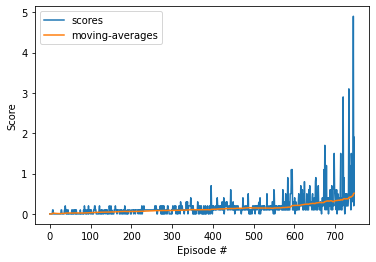

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='scores')
plt.plot(np.arange(len(scores)), moving_average, label='moving-averages')
plt.legend(loc='upper left');
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4. Watch agents

In [7]:
#load agent0 params
if os.path.exists(os.path.join('/model_dir', 'checkpoint_agent0_actor.pt')):
    agent0.actor_local.load_state_dict(torch.load(os.path.join('/model_dir','checkpoint_agent0_actor.pt', map_location='cpu')))
if os.path.exists(os.path.join('/model_dir', 'checkpoint_agent0_critic.pt')):
    agent0.critic_local.load_state_dict( torch.load(os.path.join('/model_dir', 'checkpoint_agent0_critic.pt', map_location='cpu')))    
#load agent1 params
if os.path.exists(os.path.join('/model_dir', 'checkpoint_agent1_actor.pt')):
    agent0.actor_local.load_state_dict(torch.load(os.path.join('/model_dir','checkpoint_agent1_actor.pt', map_location='cpu')))
if os.path.exists(os.path.join('/model_dir', 'checkpoint_agent1_critic.pt')):
    agent0.critic_local.load_state_dict( torch.load(os.path.join('/model_dir', 'checkpoint_agent1_critic.pt', map_location='cpu')))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1, -1))

while True:
    A0 = agent0.act(states, add_noise=False)         
    A1 = agent1.act(states, add_noise=False)        
    actions = np.concatenate((A0, A1), axis=0).flatten() 
    env_info = env.step(actions)[brain_name]        
    next_states = np.reshape(env_info.vector_observations , (1, -1))                       
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break

In [8]:
env.close()